# Geospatial Data Exploration, Analysis, and Visualization
### Some core concepts and modern geospatial data science approaches for ICESat data analysis*
*Not intended for trillions of ATL03 points

ICESat-2 hackweek  
June 18, 2019  
David Shean

OK, you've used the API, you've pulled your granules, you've extracted the relevant records and fields, and (hopueflly) done some initial QA/QC.  

Now what?  

Let's work through some modern data science tools that can help with analysis and visualization of these point data, enabling accelerated data-driven discovery.  

# Objectives

* Review fundamental concepts that are common to most geospatial analysis (e.g. coordinate systems, projections, datums, geometry types)
* Learn basic geospatial data manipulation and exploration with a relatively small, clean ICESat GLAS dataset
* Use modern data science tools (pandas/geopandas) for data exploration, interpretation, and visualization
* Explore options to capture elevation change using sparse laser altimetry data over mountain glaciers

# Tutorial prep

Open a terminal in Jupyterlab ("+" icon in upper left corner, then click on the terminal icon)

1. Navigate to local directory where you want to store tutorial material:  
`cd ~`

2. Clone the repo:  
`git clone https://github.com/ICESAT-2HackWeek/geospatial-analysis.git`

3. Enter the tutorial directory:  
`cd geospatial-analysis`

# Introduction

## The Python data science landscape

* Python, iPython, Jupyter notebook
* NumPy, Pandas, Matplotlib

## The Python geospatial landscape
* GDAL, GeoPandas, Rasterio, Cartopy, xarray

## Two complementary approaches for ICESat-2 data
1. Efficient, scalable processing of huge point datasets
    * NumPy
    * Basic manipulation
    * Array size limited by memory
2. Higher-level data science - *analysis, interpetation, and visualization*
    * NumPy under the hood, convenience/functionality comes with small performance hit
    * Labels make life easier (don't need to remember integer indices)

As with all things in the *nix/open-source/Python world, there are always multiple approaches that can be used to accomplish the same goals.  The user must decide on an approach based on complexity, time constraints, etc.

Here, we're going to explore #2 with an existing dataset.

# ICESat GLAS Background
The NASA Ice Cloud and land Elevation Satellite ([ICESat](https://icesat.gsfc.nasa.gov/icesat/)) was a NASA mission carrying the Geosciences Laser Altimeter System (GLAS) instrument: a space laser, pointed down at the Earth (and unsuspecting Earthlings).  

It measured surface elevations by precisely tracking laser pulses emitted from the spacecraft at a rate of 40 Hz (a new pulse every 0.025 seconds).  These pulses traveled through the atmosphere, reflected off the surface, back up through the atmosphere, and into space, where some small fraction of that original energy was received by a telescope on the spacecraft.  The instrument electronics precisely recorded the time when these intrepid photons left the instrument and when they returned.  The position and orientation of the spacecraft was precisely known, so the two-way traveltime (and assumptions about the speed of light and propagation through the atmosphere) allowed for precise forward determination of the spot on the Earth's surface (or cloud tops, as was often the case) where the reflection occurred.  The laser spot size varied during the mission, but was ~70 m in diameter. 

ICESat collected billions of measurements from 2003 to 2009, and was operating in a "repeat-track" mode that sacrificed spatial coverage for more observations along the same ground tracks over time.  One primary science focus involved elevation change over the Earth's ice sheets.  It allowed for early measurements of full Antarctic and Greenland ice sheet elevation change, which offered a detailed look at spatial distribution and rates of mass loss, and total ice sheet contributions to sea level rise.  

There were problems with the lasers during the mission, so it operated in short campaigns lasting only a few months to prolong the full mission lifetime.  While the primary measurements focused on the polar regions, many measurements were also collected over lower latitudes, to meet other important science objectives (e.g., estimating biomass in the Earth's forests, observing sea surface height/thickness over time). 

# Sample GLAS dataset for CONUS
A few years ago, I wanted to evaluate ICESat coverage of the Continental United States (CONUS).  The primary application was to extract a set of accurate control points to co-register a large set of high-resolution DEMs derived from satellite stereo imagery.  I wrote some Python/shell scripts to download, filter, and process all of the GLAH14 granules in parallel ([https://github.com/dshean/icesat_tools](https://github.com/dshean/icesat_tools)).

The high-level workflow is here: https://github.com/dshean/icesat_tools/blob/master/glas_proc.py#L24.  These tools processed each H5 file and wrote out csvs of “good” points, then concatenated, to prepare the input csv (`GLAH14_tllz_conus_lulcfilt_demfilt.csv`) that we will use for this tutorial.  

The csv contains ICESat GLAS shots that passed the following filters:
* Within some buffer (~110 km) of mapped glacier polygons from the Randolph Glacier Inventory (RGI)
* Returns from exposed bare ground (31) or snow/ice (12) according to a 30-m Land-use/Land-cover dataset (2011 NLCD, https://www.mrlc.gov/data?f%5B0%5D=category%3Aland%20cover)
* Elevation values within some threshold (200 m) of elevations sampled from an external reference DEM (void-filled 1/3-arcsec [30-m] SRTM-GL1), used to remove spurious points and returns from clouds.
* Various other ICESat-specific quality flags (see comments in `glas_proc.py` for details)

The final file contains a relatively small subset (~65K) of the total shots in the original GLAH14 data granules from the full mission timeline (2003-2009).  The remaining points should represent returns from the Earth's surface with reasonably high quality, and can be used for subsequent analysis.

In the end, the coverage/quality was often insufficient for the co-registration process.  Last year, I decided to take another look at the sample of ICESat GLAS points over CONUS glaciers.

## Wait a minute, I thought this was an ICESat-2 hackweek!

Note that we could (and should!) swap similarly processed/filtered points from ATLAS (e.g., ATL06) here.  I did not have time to do this before the hackweek, but it would make a great project (nudge).  After opening this updated file with Pandas, it should mostly be a matter of updating field names throughout the notebook.

# Import necessary modules

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Magic function to enable interactive plotting (zoom/pan) in Jupyter notebook
#If running locally, this would be `%matplotlib notebook`, but since we're using Juptyerlab, we use widget
#%matplotlib widget
%matplotlib inline

In [4]:
#Define path to sample GLAS data
glas_fn = 'GLAH14_tllz_conus_lulcfilt_demfilt.csv'

In [5]:
#Quick check of file contents
!head $glas_fn

decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc
2003.13957078, 731266.9433448168, 44.157897, -105.356562, 1398.51, 1400.52, 0.33, 31
2003.13957081, 731266.9433462636, 44.150175, -105.358116, 1387.11, 1384.64, 0.43, 31
2003.13957081, 731266.9433465529, 44.148632, -105.358427, 1392.83, 1383.49, 0.28, 31
2003.13957081, 731266.9433468423, 44.147087, -105.358738, 1384.24, 1382.85, 0.84, 31
2003.13957081, 731266.9433471316, 44.145542, -105.359048, 1369.21, 1380.24, 1.73, 31
2003.13957081, 731266.9433474210, 44.143996, -105.359359, 1366.60, 1375.23, 1.60, 31
2003.13957081, 731266.9433506038, 44.126969, -105.362876, 1355.14, 1379.38, 2.17, 31
2003.13957084, 731266.9433604418, 44.074358, -105.373549, 1369.53, 1391.71, 2.88, 31
2003.13957084, 731266.9433607311, 44.072806, -105.373864, 1380.02, 1387.79, 0.45, 31


# pandas

Trust me, you should learn how to use pandas, regardless of your ICESat-2 application.  

A significant portion of the Python data science ecosystem is based on Pandas and/or Pandas data models.

>"pandas is a Python package providing fast, flexible, and expressive data structures designed to make working with "relational" or "labeled" data both easy and intuitive. It aims to be the fundamental high-level building block for doing practical, real world data analysis in Python. Additionally, it has the broader goal of becoming the most powerful and flexible open source data analysis / manipulation tool available in any language. It is already well on its way towards this goal."

https://github.com/pandas-dev/pandas#main-features

If you are working with tabular data, especially time series data, pandas is your friend.

## Load the csv

We'll use the `read_csv` function here to load the data into a DataFrame.

Note that pandas has excellent readers for most common file formats: https://pandas.pydata.org/pandas-docs/stable/reference/io.html

In [6]:
glas_df = pd.read_csv(glas_fn)
#That's it!

## Inspect the DataFrame

Core pandas data structure for labeled, tabular data: DataFrame

* full output
* columns
* head, tail
* describe
* Applying ufunc

In [7]:
glas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65236 entries, 0 to 65235
Data columns (total 8 columns):
decyear      65236 non-null float64
ordinal      65236 non-null float64
lat          65236 non-null float64
lon          65236 non-null float64
glas_z       65236 non-null float64
dem_z        65236 non-null float64
dem_z_std    65236 non-null float64
lulc         65236 non-null int64
dtypes: float64(7), int64(1)
memory usage: 4.0 MB


In [8]:
glas_df.columns

Index(['decyear', 'ordinal', 'lat', 'lon', 'glas_z', 'dem_z', 'dem_z_std',
       'lulc'],
      dtype='object')

In [9]:
glas_df.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31


In [10]:
glas_df.describe()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc
count,65236.000000,65236.000000,65236.000000,65236.000000,65236.000000,65236.000000,65236.000000,65236.000000
mean,2005.945322,732291.890372,40.946798,-115.040612,1791.494167,1792.260964,5.504748,30.339444
std,1.729573,631.766682,3.590476,5.465065,1037.183482,1037.925371,7.518558,3.480576
min,2003.139571,731266.943345,34.999455,-124.482406,-115.550000,-114.570000,0.000000,12.000000
25%,2004.444817,731743.803182,38.101451,-119.257599,1166.970000,1168.240000,0.070000,31.000000
50%,2005.846896,732256.116938,39.884541,-115.686241,1555.730000,1556.380000,1.350000,31.000000
75%,2007.223249,732758.486046,43.453565,-109.816475,2399.355000,2400.072500,9.530000,31.000000
max,2009.775995,733691.238341,48.999727,-104.052336,4340.310000,4252.940000,49.900000,31.000000


In [11]:
glas_df.mean()

decyear        2005.945322
ordinal      732291.890372
lat              40.946798
lon            -115.040612
glas_z         1791.494167
dem_z          1792.260964
dem_z_std         5.504748
lulc             30.339444
dtype: float64

## Create a 2D scatterplot
Use pandas built-in convenience plotting function

A note on colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

Another great resource (Thanks @fperez!): https://matplotlib.org/cmocean/

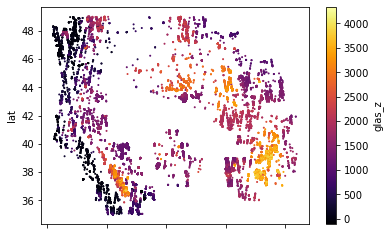

In [12]:
glas_df.plot(x='lon', y='lat', kind='scatter', c='glas_z', s=1, cmap='inferno')

## Create a 3D scatterplot
Some lag, not very useful, but just so you know...

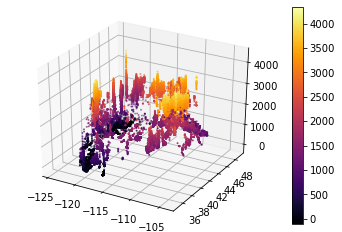

In [13]:
from mpl_toolkits.mplot3d import Axes3D
f = plt.figure()
ax3D = f.add_subplot(111, projection='3d')
sc = ax3D.scatter(glas_df['lon'], glas_df['lat'], glas_df['glas_z'], c=glas_df['glas_z'], s=1, cmap='inferno')
#sc = ax3D.scatter(glas_df['lon'], glas_df['lat'], glas_df['glas_z'], c=glas_df['decyear'], s=1, cmap='inferno')
plt.colorbar(sc)

## Create a histogram of GLAS elevation values

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd7dc8e6160>]],
      dtype=object)

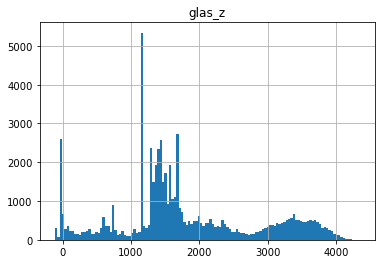

In [14]:
glas_df.hist('glas_z', bins=128)

## A note on vertical datums

Note that some elevations are less than 0 m.  How can this be?

These are height values above (or below) the WGS84 ellipsoid.  Is this the same thing as mean sea level?

https://vdatum.noaa.gov/docs/datums.html

![Geodetic vs. Orthometric height](https://geodesy.noaa.gov/GEOID/IMAGES/d05.jpg)

## Check spatial distribution of points below 0 (height above WGS84 ellipsoid)

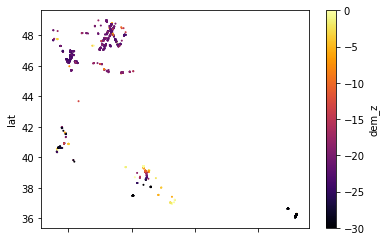

In [15]:
ax = glas_df[glas_df['glas_z'] < 0].plot(x='lon', y='lat', kind='scatter', c='dem_z', s=1, cmap='inferno', vmin=-30, vmax=0)

## Geoid offset
Height differene between the WGS84 ellipsoid (simple shape model of the Earth) and a geoid, that approximates a geopotential (gravitational) surface, approximately mean sea level.

EGM96 geoid offset grid

https://upload.wikimedia.org/wikipedia/commons/3/3b/Earth_Gravitational_Model_1996.png

![EGM96 geoid offset grid](https://upload.wikimedia.org/wikipedia/commons/3/3b/Earth_Gravitational_Model_1996.png)

Note values for CONUS.  

A lot of the points with elevation < 0 m in the above plot are near coastal sites, roughly near mean sea level.  We see that the geoid offset (difference between WGS84 ellipsoid and EGM96 geoid in this case) for CONUS is roughly -20 m.  So the ICESat GLAS point elevations relative to the ellipsoid near the coast are roughly -20 m, even though they are 0 m relative to the geoid (approximately mean sea level).

## Compute the elevation difference between ICESat glas_z and SRTM dem_z values

Earlier, I mentioned that I had sampled the SRTM-GL1 DEM for each GLAS shot.  Let's compute the difference and store in a new column in our DataFrame called `glas_srtm_dh`

Remember the order of this calculation (if output difference values are negative, which dataset is higher?)

In [16]:
glas_df['glas_srtm_dh'] = glas_df['glas_z'] - glas_df['dem_z']
glas_df.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_srtm_dh
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,-2.01
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,2.47
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,9.34
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,1.39
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,-11.03


## Compute the difference between ICESat point timestamp and SRTM timestamp

In [17]:
#February 11-22, 2000
srtm_decyear = 2000.112
glas_df['glas_srtm_dt'] = glas_df['decyear'] - srtm_decyear
glas_df.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_srtm_dh,glas_srtm_dt
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,-2.01,3.027571
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,2.47,3.027571
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,9.34,3.027571
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,1.39,3.027571
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,-11.03,3.027571


## Compute (apparent) elevation change rates between 2000 and 2003-2009 (m/yr)

In [18]:
glas_df['glas_srtm_dhdt'] = glas_df['glas_srtm_dh']/glas_df['glas_srtm_dt']
glas_df.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_srtm_dh,glas_srtm_dt,glas_srtm_dhdt
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,-2.01,3.027571,-0.663899
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,2.47,3.027571,0.815836
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,9.34,3.027571,3.084982
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,1.39,3.027571,0.459114
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,-11.03,3.027571,-3.643185


## Create a scatterplot of difference values
* Use a symmetrical `RdBu` (Red to Blue) colormap
* Set the colormap limits using `vmin` and `vmax` keyword arguments to be symmetrical about 0 with appropriate range to bring out relevant detail

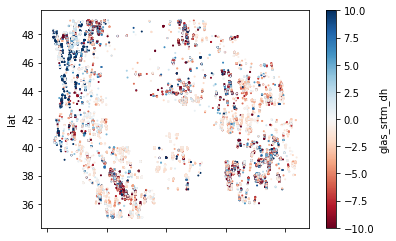

In [19]:
ax = glas_df.plot(x='lon', y='lat', kind='scatter', c='glas_srtm_dh', s=1, cmap='RdBu', vmin=-10, vmax=10)

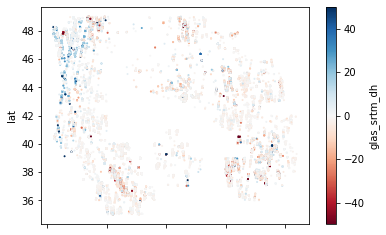

In [20]:
ax = glas_df.plot(x='lon', y='lat', kind='scatter', c='glas_srtm_dh', s=1, cmap='RdBu', vmin=-50, vmax=50)

## Create a histogram of the difference values
* Increase the number of bins, and limit the range to something reasonable

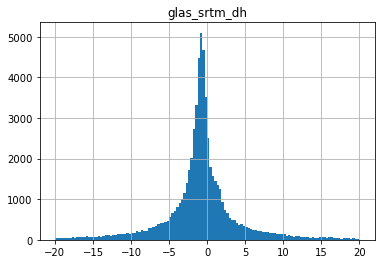

In [21]:
out = glas_df.hist('glas_srtm_dh', bins=128, range=(-20,20))

## Create a scatterplot of elevation difference vs. elevation

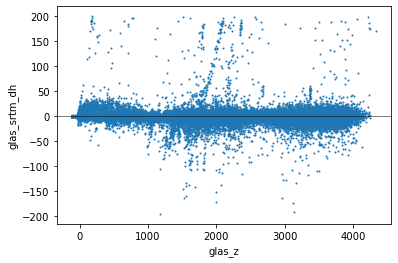

In [22]:
ax = glas_df.plot('glas_z', 'glas_srtm_dh', kind='scatter', s=1)
#Add a horizontal line at 0
ax.axhline(0, color='k', lw=0.5);

## Remove outliers
The initial filter in `glas_proc.py` removed GLAS points with absolute elevation difference >200 m compared to the SRTM elevations.  We expect most real elevation change signals to be less than this for the given time period.  But clearly some outliers remain.

Use a simple sigma filter

In [23]:
print("Mean difference:", glas_df['glas_srtm_dh'].mean())
thresh = 3.5 * glas_df['glas_srtm_dh'].std()
print("3.5 * std:", thresh)

Mean difference: -0.7667968606291014
3.5 * std: 43.271695327333795


In [24]:
idx = (glas_df['glas_srtm_dh'] - glas_df['glas_srtm_dh'].mean()).abs() <= thresh
glas_df_fltr = glas_df[idx]
print("Number of points before filter:", glas_df.shape[0])
print("Number of points after filter:", glas_df_fltr.shape[0])

Number of points before filter: 65236
Number of points after filter: 64589


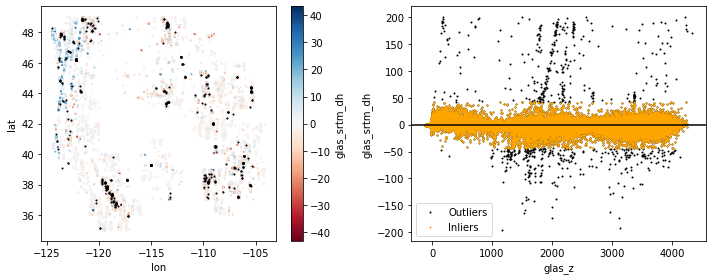

In [25]:
clim = thresh
f, axa = plt.subplots(1,2, figsize=(10,4))
glas_df.plot(ax=axa[1], x='glas_z', y='glas_srtm_dh', kind='scatter', s=1, color='k', label='Outliers')
glas_df_fltr.plot(ax=axa[0], x='lon', y='lat', kind='scatter', c='glas_srtm_dh', s=1, cmap='RdBu', vmin=-clim, vmax=clim)
glas_df_fltr.plot(ax=axa[1], x='glas_z', y='glas_srtm_dh', kind='scatter', s=1, c='orange', label='Inliers')
glas_df[~idx].plot(ax=axa[0], x='lon', y='lat', kind='scatter', color='k', s=1, legend=False)
axa[1].axhline(0,color='k')
plt.tight_layout()

## Active remote sensing sanity check

OK, we removed some outliers.  But there are still some big differences between the SRTM and GLAS elevation.  

* Do you see systematic differences between the glas_z and dem_z values?
* Any clues from the scatterplot? (e.g., do some tracks (north-south lines of points) display systematic bias?)
* Brainstorm some ideas about what might be going on here.  Think about the nature of each sensor:
    * ICESat was a Near-IR laser (1064 nm wavelength) with a big ground spot size (~70 m in diameter)
        * Timestamps span different seasons between 2003-2009
    * SRTM was a C-band radar (5.3 GHz, 5.6 cm wavelength) with approximately 30 m ground sample distance (pixel size)
        * Timestamp was February 2000
        * Data gaps (e.g., radar shadows, steep slopes) were filled with ASTER GDEM2 composite, which blends DEMs acquired over many years ~2000-2014
* Consider different surfaces and how the laser/radar footprint might be affected:
    * Flat bedrock surface
    * Dry sand dunes
    * Steep montain topography like the Front Range in Colorado  
    * Dense vegetation of the Hoh Rainforest in Olympic National Park

# Geopandas

pandas is great, but what if we want to do some geospatial operations - like compute the intersection between Point and Polygon features?

Enter Geopandas - all the great things about pandas, plus geo! (http://geopandas.org/).

>"GeoPandas is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting."

>"GeoPandas enables you to easily do operations in python that would otherwise require a spatial database such as PostGIS."

Under the hood, GeoPandas is pandas plus some other core geospatial packages:
* `shapely` for geometry operations (https://shapely.readthedocs.io/en/stable/manual.html)
* `fiona` for reading/writing GIS file formats (https://fiona.readthedocs.io/en/latest/manual.html)
* `pyproj` for projections and coordinate system transformations (http://pyproj4.github.io/pyproj/stable/)

Under those hoods are lower-level geospatial libraries (GEOS, GDAL/OGR, PROJ4) that provide a foundation for most GIS software (open-source and commercial).  I encourage you to explore these - I guarantee you will learn something valuable.

For now, let's explore some basic geopandas functionality.

## Convert pandas `DataFrame` to geopandas `GeoDataFrame`
To do this, we need to create a new column containing standardized `geometry` objects (e.g., `Point`, `Polygon`) for each record in the DataFrame. 

https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html

### Create a new geometry column containing (x,y) tuples for each record

In [26]:
glas_df['geometry'] = list(zip(glas_df['lon'], glas_df['lat']))

In [27]:
glas_df.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_srtm_dh,glas_srtm_dt,glas_srtm_dhdt,geometry
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,-2.01,3.027571,-0.663899,"(-105.35656200000001, 44.157897)"
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,2.47,3.027571,0.815836,"(-105.358116, 44.150175)"
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,9.34,3.027571,3.084982,"(-105.358427, 44.148632)"
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,1.39,3.027571,0.459114,"(-105.35873799999999, 44.147087)"
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,-11.03,3.027571,-3.643185,"(-105.359048, 44.145542)"


### Create new shapely Point geometry objects from the (lon,lat) tuple
Can do this as `Point(lon, lat)`, but let's use Pandas `apply` function to apply to the entire column

In [28]:
glas_df['geometry'] = glas_df['geometry'].apply(Point)

In [29]:
glas_df.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_srtm_dh,glas_srtm_dt,glas_srtm_dhdt,geometry
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,-2.01,3.027571,-0.663899,POINT (-105.356562 44.157897)
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,2.47,3.027571,0.815836,POINT (-105.358116 44.150175)
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,9.34,3.027571,3.084982,POINT (-105.358427 44.148632)
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,1.39,3.027571,0.459114,POINT (-105.358738 44.147087)
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,-11.03,3.027571,-3.643185,POINT (-105.359048 44.145542)


### Now create new GeoDataFrame object, passing the updated Pandas DataFrame
Define coordinate reference system (4326 is geographic lat/lon on WGS84 Ellispoid)  
Note different variable name (`glas_gdf` vs earlier `glas_df`)

In [30]:
glas_gdf = gpd.GeoDataFrame(glas_df, crs={'init' :'epsg:4326'})

In [31]:
glas_gdf.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_srtm_dh,glas_srtm_dt,glas_srtm_dhdt,geometry
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,-2.01,3.027571,-0.663899,POINT (-105.356562 44.157897)
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,2.47,3.027571,0.815836,POINT (-105.358116 44.150175)
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,9.34,3.027571,3.084982,POINT (-105.358427 44.148632)
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,1.39,3.027571,0.459114,POINT (-105.358738 44.147087)
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,-11.03,3.027571,-3.643185,POINT (-105.359048 44.145542)


In [32]:
type(glas_gdf)

geopandas.geodataframe.GeoDataFrame

In [33]:
type(glas_df)

pandas.core.frame.DataFrame

## Create a quick 2D scatterplot

Like a Pandas DataFrame, a GeoDataFrame has convenience plotting function that is built on matlplotlib

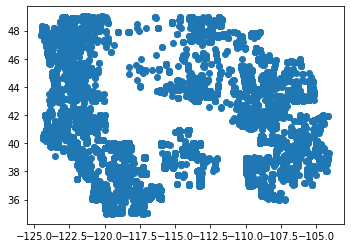

In [34]:
glas_gdf.plot();

OK, looks like a scatterplot.  But let's plot the elevation values with a color ramp.  
To do this, just specify the column name as the first argument to `plot`:

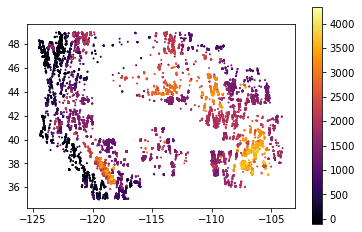

In [35]:
glas_gdf.plot('glas_z', markersize=1, cmap='inferno', legend=True);

# RGI glacier polygons

Let's grab some glacier outline poygons from the Randolph Glacier Inventory (RGI) v6.0: https://www.glims.org/RGI/

In [36]:
#Fetch the zip file for Region 02 (Western North America)
#Use the wget command (the -nc is "no-clobber", so will not overwrite existing file)
!wget -nc https://www.glims.org/RGI/rgi60_files/02_rgi60_WesternCanadaUS.zip

--2019-06-20 09:42:36--  https://www.glims.org/RGI/rgi60_files/02_rgi60_WesternCanadaUS.zip
Resolving www.glims.org (www.glims.org)... 128.138.135.43
Connecting to www.glims.org (www.glims.org)|128.138.135.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20937343 (20M) [application/zip]
Saving to: ‘02_rgi60_WesternCanadaUS.zip’

02_rgi60_WesternCan 100%[===================>]  19.97M  9.21MB/s    in 2.2s    

2019-06-20 09:42:39 (9.21 MB/s) - ‘02_rgi60_WesternCanadaUS.zip’ saved [20937343/20937343]



In [37]:
#Extract to rgi subdirectory
!unzip -n -d rgi 02_rgi60_WesternCanadaUS.zip

Archive:  02_rgi60_WesternCanadaUS.zip
  inflating: rgi/02_rgi60_WesternCanadaUS.dbf  
  inflating: rgi/02_rgi60_WesternCanadaUS.prj  
  inflating: rgi/02_rgi60_WesternCanadaUS.shp  
  inflating: rgi/02_rgi60_WesternCanadaUS.shx  
  inflating: rgi/02_rgi60_WesternCanadaUS_hypso.csv  


In [38]:
#Specify the shapefile filename
rgi_fn = 'rgi/02_rgi60_WesternCanadaUS.shp'

## Load RGI shapefile using Geopandas

In [39]:
rgi_gdf = gpd.read_file(rgi_fn)

That's it!

In [40]:
#By default a new integer index is created.  Let's just use the RGI ID as our index
rgi_gdf = rgi_gdf.set_index('RGIId')

## Inspect the RGI GeoDataFrame
Note the geometry type is POLYGON

In [41]:
rgi_gdf.head()

,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,Zmax,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
RGIId,,,,,,,,,,,,,,,,,,,,,
RGI60-02.00001,G238765E49002N,20049999,20069999,-121.235,49.0019,2,4,0.073,1938,2135,...,345,304,0,0,0,0,0,9,None,"POLYGON ((-121.237179 49.00120000000004, -121...."
RGI60-02.00002,G238410E49162N,20049999,20069999,-121.590,49.1617,2,4,0.262,1726,2105,...,6,817,0,0,0,0,0,9,None,POLYGON ((-121.5911819999999 49.15867800000007...
RGI60-02.00003,G238791E49163N,20049999,20069999,-121.209,49.1627,2,4,0.307,2002,2309,...,100,478,0,0,0,0,0,9,None,"POLYGON ((-121.207506 49.16608200000007, -121...."
RGI60-02.00004,G238399E49166N,20049999,20069999,-121.601,49.1657,2,4,0.184,1563,1834,...,15,376,0,0,0,0,0,9,None,POLYGON ((-121.5965409999999 49.16728500000005...
RGI60-02.00005,G238389E49167N,20049999,20069999,-121.611,49.1666,2,4,0.274,1668,2101,...,50,676,0,0,0,0,0,9,None,POLYGON ((-121.6079999999999 49.16802400000006...


## Create a quick plot

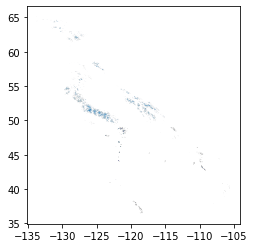

In [42]:
rgi_gdf.plot();

## Load and plot state polygons for context


Hmmm, let's see.  Two choices:
1. We could go to ESRI or the U.S. Census website, identify and download a shapefile, unzip 4+ files, copy/paste the appropriate \*.shp filename into the notebook.  Wait, how can I download on a remote server?  OK, maybe run something like `wget http://...`, unzip, provide absolute path  
*- OR -*
2. Give geopandas a url that points to a GeoJSON file somewhere on the web, and read dynamically

Yeah, let's go with #2

Let's use the US States 5M GeoJSON here: http://eric.clst.org/tech/usgeojson/

We've heard GeoJSON mentioned a few times this week.  It's a great format.  If you are unfamiliar: https://en.wikipedia.org/wiki/GeoJSON

In [43]:
#1:5000000 scale polygons
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
#1:500000 scale polygons (larger file, more vertices)
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'

In [44]:
states_gdf = gpd.read_file(states_url)

### Inspect State GeoDataFrame
Note that some geometry entries are tuples of POLYGON objects - these are states with islands or rings

In [45]:
states_gdf.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,,50645.326,"(POLYGON ((-88.124658 30.28364, -88.0868119999..."
1,0400000US02,02,Alaska,,570640.950,"(POLYGON ((-166.10574 53.988606, -166.075283 5..."
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.538593 37.000674, -112.534545 3..."
3,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.042964 33.019219, -94.043036 33...."
4,0400000US06,06,California,,155779.220,"(POLYGON ((-122.421439 37.869969, -122.421341 ..."


### Update our quick plot of RGI polygons

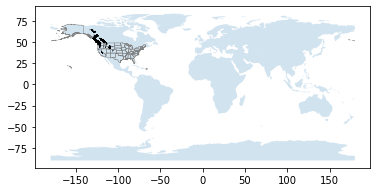

In [46]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(alpha=0.2)
states_gdf.plot(ax=ax, facecolor='none', edgecolor='0.5', linewidth=0.5)
rgi_gdf.plot(ax=ax, edgecolor='k', linewidth=0.5)

## Clip RGI polygons to CONUS
GeoPandas makes spatial selection easy.  

We'll discuss two options: 1) using a bounding box, and 2) using a polygon.

### 1. Bounding box

In [47]:
glas_gdf.total_bounds

array([-124.482406,   34.999455, -104.052336,   48.999727])

#### Define min/max variables for each dimension

In [48]:
xmin, ymin, xmax, ymax = glas_gdf.total_bounds

#### Create new GeoDataFrame from output of simple spatial filter with GeoPandas `cx` function

In [49]:
rgi_gdf_conus = rgi_gdf.cx[xmin:xmax, ymin:ymax]

#### Quick plot to verify

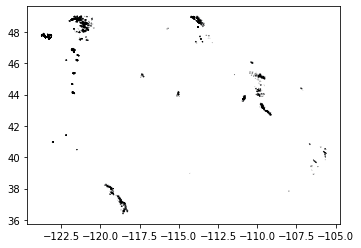

In [50]:
rgi_gdf_conus.plot(edgecolor='k');

### 2. Clip points to arbitrary Polygon geometry

Let's define a Polygon around our area of interest (the GLAS points) 

To do this, we'll first take the union of our ~65K GLAS points, and then compute the convex hull

This will return a Polygon geometry object, which renders nicely in the Jupyter notebook

In [51]:
glas_gdf_chull = glas_gdf.unary_union.convex_hull

In [52]:
#Check the type
type(glas_gdf_chull)

shapely.geometry.polygon.Polygon

#### Preview geometry
Note that geometry objects (points, lines, polygons, etc.) will render directly in the Jupyter notebook!  Great for quick previews.

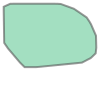

In [53]:
glas_gdf_chull

#### Compute intersection between all RGI polygons and the convex hull
Use the GeoDataFrame `intersects()` function.  
This will return a Boolean DataSeries, True if points intersect the polygon, False if they do not

In [54]:
rgi_gdf_idx = rgi_gdf.intersects(glas_gdf_chull)

In [55]:
rgi_gdf_idx.head()

RGIId
RGI60-02.00001    False
RGI60-02.00002    False
RGI60-02.00003    False
RGI60-02.00004    False
RGI60-02.00005    False
dtype: bool

#### Extract records with True for the intersection

In [56]:
print("Number of RGI polygons before:",rgi_gdf.shape[0])
rgi_gdf_conus = rgi_gdf[rgi_gdf_idx]
print("Number of RGI polygons after:", rgi_gdf_conus.shape[0])

Number of RGI polygons before: 18855
Number of RGI polygons after: 5149


#### Quick plot to verify
Note latitude range

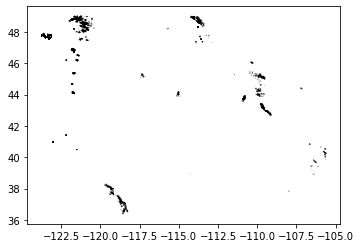

In [57]:
rgi_gdf_conus.plot(edgecolor='k')

# Projection

All of the above examples used standard geodetic lat/lon (EPSG:4326).  This is fine for global analyses and basic visualization.  But as you know, the width of a degree of longitude varies with latitude (~111 km near equator, ~0 m near pole), so we have a scaling problem.

So we need to choose a map projection that is appropriate for our data.  This decision is important for visualization, but is also critical for precise quantitative analysis.  For example, if you want to compute volume change, you should use an equal-area projection.  If you want to calculate true distances between two points, you should use an equidistant projection.  

https://www.axismaps.com/guide/general/map-projections/

## Define a projection for CONUS

Let's use a custom Albers Equal Area projection to minimize distoration over the full spatial extent of our GLAS points

To do this, we'll define a PROJ4 string (https://proj.org/usage/quickstart.html?highlight=definition), which can be interpreted by most Python geopackages (like `pyproj`).

The Albers Equal Area projection requires two standard parallels: https://proj.org/operations/projections/aea.html.  We'll use a center lat/lon here.

In [58]:
conus_aea_proj4 = '+proj=aea +lat_1=37.31 +lat_2=46.69 +lat_0=42.00 +lon_0=-114.27 +ellps=WGS84 +units=m +no_defs'

## Reproject the GLAS points

This is simple with the GeoDataFrame `to_crs()` method, which uses pyproj under the hood.

We'll store as a new GeoDataFrame.

In [59]:
glas_gdf_aea = glas_gdf.to_crs(conus_aea_proj4)

## Check the updated geometry
Note the change in coordinates

In [60]:
glas_gdf_aea.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_srtm_dh,glas_srtm_dt,glas_srtm_dhdt,geometry
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,-2.01,3.027571,-0.663899,POINT (709799.202481625 277341.4644630185)
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,2.47,3.027571,0.815836,POINT (709764.9868479106 276472.8763755658)
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,9.34,3.027571,3.084982,POINT (709758.1079927931 276299.311774242)
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,1.39,3.027571,0.459114,POINT (709751.2509753814 276125.5253733542)
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,-11.03,3.027571,-3.643185,POINT (709744.4720842609 275951.747074242)


## Plot the projected points

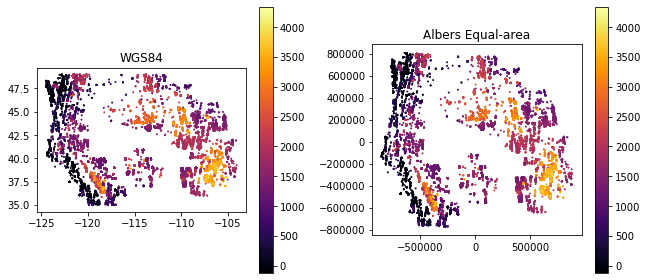

In [61]:
f, axa = plt.subplots(1,2, figsize=(9,4))
glas_gdf.plot(ax=axa[0], column='glas_z', cmap='inferno', markersize=1, legend=True)
axa[0].set_title('WGS84')
glas_gdf_aea.plot(ax=axa[1], column='glas_z', cmap='inferno', markersize=1, legend=True)
axa[1].set_title('Albers Equal-area')
plt.tight_layout()

## OK, great, but what did we just do?

Under the hood, GeoPandas used the pyproj library (a Python API for PROJ) to transform each point from one coordinate system to another coordinate system.  

You've all done this kind of thing before: https://en.wikipedia.org/wiki/List_of_common_coordinate_transformations

In 2D, transforming (x,y) coordinates between different projections (e.g., WGS84 vs. Albers Equal Area) on the same reference ellipsoid is pretty straightforward.  Things start to get more complicated when you include different ellipsoid models, horizontal/vertical datums, etc.  Oh, also the Earth's surface is not static - plate tectonics make everything more complicated, as time becomes important, and transformations must include a "kinematic" component.  

Fortunately, the PROJ library (https://proj4.org/about.html) has generalized much of the complicated math for geodetic coordinate transformations.  It's been under development since the 1980s, and our understanding of the Earth's shape and plate motions has changed dramatically in that time period.  So, still pretty complicated, and there are different levels of support/sophistication in the tools/libraries that use PROJ (like fiona or GeoPandas).

We aren't going to get into the details here, but feel free to take a look at the Transformations section here to get a sense of how this is actually accomplished: https://proj4.org/operations/index.html

# Combined plot

In [62]:
bbox = glas_gdf_aea.total_bounds

In [63]:
# Reproject the state and RGI polygons
states_gdf_aea = states_gdf.to_crs(conus_aea_proj4)
rgi_gdf_conus_aea = rgi_gdf_conus.to_crs(conus_aea_proj4)

(-772261.0866023174, 808966.8211379822)

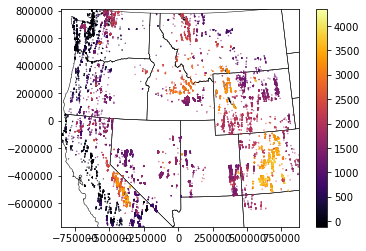

In [64]:
ax = states_gdf_aea.plot(edgecolor='k', facecolor='none', lw=0.5)
rgi_gdf_conus_aea.plot(ax=ax, edgecolor='k', lw=0.5, alpha=0.5)
glas_gdf_aea.plot(ax=ax, column='glas_z', cmap='inferno', markersize=0.1, legend=True)
#glas_gdf_aea.plot(ax=ax, column='decyear', cmap='inferno', markersize=1, legend=True)
ax.set_xlim(bbox[[0,2]])
ax.set_ylim(bbox[[1,3]])

# Hexbin plots

Hexbin plots are great for visualizing spatial distribution of binned point density or other metric (e.g., bin median). 

They are preferable over a standard square/rectangular grid: https://pro.arcgis.com/en/pro-app/tool-reference/spatial-statistics/h-whyhexagons.htm

Here are some resources on generating hexbins using Python and matplotlib:
* https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hexbin.html
* http://darribas.org/gds15/content/labs/lab_09.html

Note: an equal-area projection is also a good idea for a hexbin plot.

In [65]:
nbins = 40

In [66]:
#To calculate number of bins dynamically with specified bin spacing in meters
#bin_width = 27000 #meters
#nbins_x = int(np.ceil(np.abs(bbox[2] - bbox[0])/bin_width))
#nbins_y = int(np.ceil(np.abs(bbox[3] - bbox[1])/bin_width))
#print(nbins_x, nbins_y)
#nbins = nbins_x

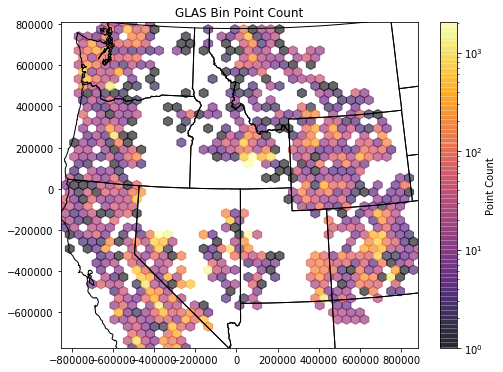

In [67]:
f,ax = plt.subplots(figsize=(8,6))
hb = ax.hexbin(glas_gdf_aea.geometry.x, glas_gdf_aea.geometry.y, gridsize=nbins, cmap='inferno', bins='log', alpha=0.6, mincnt=1)
plt.colorbar(hb, label='Point Count')
states_gdf_aea.plot(ax=ax, facecolor='none', edgecolor='black');
ax.set_xlim(bbox[[0,2]]);
ax.set_ylim(bbox[[1,3]]);
ax.set_title('GLAS Bin Point Count');

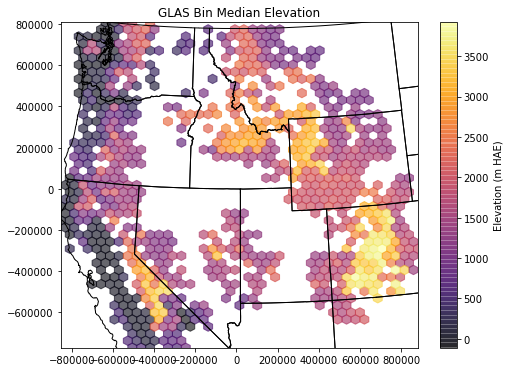

In [68]:
f,ax = plt.subplots(figsize=(8,6))
hb = ax.hexbin(glas_gdf_aea.geometry.x, glas_gdf_aea.geometry.y, C=glas_gdf_aea['glas_z'], \
               reduce_C_function=np.median, gridsize=nbins, cmap='inferno', alpha=0.6)
plt.colorbar(hb, ax=ax, label='Elevation (m HAE)')
states_gdf_aea.plot(ax=ax, facecolor='none', edgecolor='black');
ax.set_xlim(bbox[[0,2]]);
ax.set_ylim(bbox[[1,3]]);
ax.set_title('GLAS Bin Median Elevation');

# Part 2: Analysis of (apparent) elevation change over CONUS glaciers

Let's try to consider the following:

*Can we identify CONUS glacier surface elevation change that occurred between SRTM (2000) and GLAS (2003-2009) data collection?*

## Merge GLAS points with RGI polygons
Earlier, we selected RGI polygons using a bounding box, and then did a simple intersection with a polygon.  

Now, let's find the GLAS points that intersect **each** RGI glacier polygon.  

One approach would be to loop through each glacier polygon, and do an intersection operation like we did with the convex hull.  But this is inefficient, and won't scale well.  It is much more efficient to do a spatial join between the points and the polygons with the intersection operator.  

You all probably learned how to perform a join or spatial join in a GIS.  So, do we need to open ArcMap or QGIS here?  Do we need a full-fledged spatial database like PostGIS?  No!  GeoPandas has you covered.

http://geopandas.org/reference/geopandas.sjoin.html#geopandas.sjoin

### To simplify, let's isolate relevant columns in RGI GeoDataFrame

In [69]:
glas_gdf_aea.columns

Index(['decyear', 'ordinal', 'lat', 'lon', 'glas_z', 'dem_z', 'dem_z_std',
       'lulc', 'glas_srtm_dh', 'glas_srtm_dt', 'glas_srtm_dhdt', 'geometry'],
      dtype='object')

In [70]:
rgi_gdf_conus_aea.columns

Index(['GLIMSId', 'BgnDate', 'EndDate', 'CenLon', 'CenLat', 'O1Region',
       'O2Region', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax',
       'Status', 'Connect', 'Form', 'TermType', 'Surging', 'Linkages', 'Name',
       'geometry'],
      dtype='object')

In [71]:
#Just use these columns from RGI
rgi_col = ['Area','Name','geometry']

## Perform the spatial join
We'll use the intersection operation, and only return points that actually intersect glacier polygons.  Let's store this in a new GeoDataFrame.

In [72]:
glas_gdf_aea_rgi = gpd.sjoin(glas_gdf_aea, rgi_gdf_conus_aea[rgi_col], op='intersects', how='inner')

In [73]:
#The join uses "index_right" for the RGI index column name.  Let's rename to RGIId
glas_gdf_aea_rgi = glas_gdf_aea_rgi.rename(columns={"index_right": "RGIId"})

In [74]:
glas_gdf_aea_rgi.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_srtm_dh,glas_srtm_dt,glas_srtm_dhdt,geometry,RGIId,Area,Name
1032,2003.162887,731275.453606,48.672276,-121.532290,1798.45,1791.25,5.63,12,7.20,3.050887,2.359970,POINT (-536290.6968751887 765027.7300854146),RGI60-02.17369,2.819,Noisy Creek Glacier
5393,2003.753883,731491.167315,48.669686,-121.525707,1826.79,1832.08,8.82,12,-5.29,3.641883,-1.452545,POINT (-535829.9284047344 764700.7641614984),RGI60-02.17369,2.819,Noisy Creek Glacier
5394,2003.753883,731491.167315,48.671225,-121.526056,1795.05,1795.39,3.60,12,-0.34,3.641883,-0.093358,POINT (-535841.2584876922 764872.8200801831),RGI60-02.17369,2.819,Noisy Creek Glacier
5395,2003.753883,731491.167315,48.672763,-121.526408,1768.91,1768.20,3.47,12,0.71,3.641883,0.194954,POINT (-535852.8175845263 765044.7837475365),RGI60-02.17369,2.819,Noisy Creek Glacier
5396,2003.753883,731491.167316,48.674303,-121.526762,1745.11,1745.54,3.98,12,-0.43,3.641883,-0.118071,POINT (-535864.5039730374 765216.9800739347),RGI60-02.17369,2.819,Noisy Creek Glacier


## Check number of records

In [75]:
print("Number of RGI polygons before:", rgi_gdf_conus_aea.shape[0])
print("Number of GLAS points before:", glas_gdf_aea.shape[0])
print("Number of GLAS points that intersect RGI polygons:", glas_gdf_aea_rgi.shape[0])

Number of RGI polygons before: 5149
Number of GLAS points before: 65236
Number of GLAS points that intersect RGI polygons: 822


## Check number of GLAS points per RGI polygon

In [76]:
glas_gdf_aea_rgi['RGIId'].value_counts().head()

RGI60-02.14588    49
RGI60-02.13805    45
RGI60-02.17727    43
RGI60-02.14005    33
RGI60-02.14103    30
Name: RGIId, dtype: int64

## Which glacier has the greatest number of points?

https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/

In [77]:
label = glas_gdf_aea_rgi['RGIId'].value_counts().index[0]
print(label)
rgi_gdf_conus_aea.loc[label]['Name']

RGI60-02.14588


'Swift Glacier WA'

In [78]:
rgi_gdf_conus_aea.loc[label]

GLIMSId                                        G237815E46186N
BgnDate                                              19809999
EndDate                                              -9999999
CenLon                                               -122.185
CenLat                                                46.1858
O1Region                                                    2
O2Region                                                    4
Area                                                    0.327
Zmin                                                     1990
Zmax                                                     2484
Zmed                                                     2261
Slope                                                    25.9
Aspect                                                    157
Lmax                                                     1088
Status                                                      0
Connect                                                     0
Form    

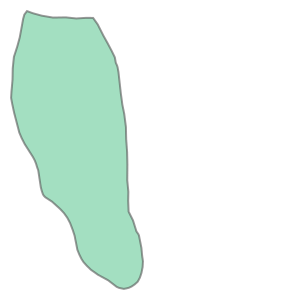

In [79]:
rgi_gdf_conus_aea.loc[label].geometry

## ipyleaflet plot

OK, great, but where is this glacier?  Let's plot on an interactive ipyleaflet map.

Note that leaflet uses tiled basemaps, with default projection of Web Mercator (EPSG:3857): https://en.wikipedia.org/wiki/Web_Mercator_projection.  Works well for lower latitudes, but not the polar regions.  I know QGIS can reproject tiled basemaps on the fly - I haven't tested with ipyleaflet.

In [80]:
from ipyleaflet import Map, Marker, basemaps

In [81]:
#Look at all of the basemap options!
basemaps.keys()

dict_keys(['OpenStreetMap', 'OpenTopoMap', 'OpenMapSurfer', 'Hydda', 'Esri', 'HikeBike', 'MtbMap', 'CartoDB', 'NASAGIBS', 'Strava', 'Stamen'])

In [82]:
center = (rgi_gdf_conus_aea.loc[label]['CenLat'], rgi_gdf_conus_aea.loc[label]['CenLon'])
basemap = basemaps.Stamen.Terrain
m = Map(center=center, zoom=12, basemap=basemap)
#label=rgi_gdf_conus_aea.loc[label]['Name']
marker = Marker(location=center, draggable=True)
m.add_layer(marker);
display(m)

Map(basemap={'url': 'http://stamen-tiles-a.a.ssl.fastly.net/terrain/{z}/{x}/{y}.png', 'attribution': 'Map tile…

## Plot points and RGI polygons, Zoom in on WA state

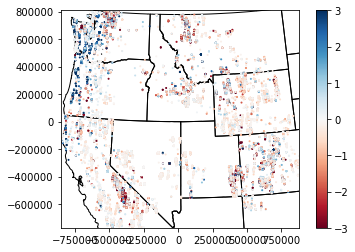

In [83]:
clim = (-3.0, 3.0)
ax=states_gdf_aea.plot(facecolor='none', edgecolor='black');
rgi_gdf_conus_aea.plot(ax=ax, edgecolor='k', lw=0.5, alpha=0.1);
glas_gdf_aea.plot(ax=ax, column='glas_srtm_dhdt', cmap='RdBu', markersize=1, legend=True, vmin=clim[0], vmax=clim[1])
ax.set_xlim(bbox[[0,2]]);
ax.set_ylim(bbox[[1,3]]);

## Groupby and Aggregate

OK, so we know that our sampling isn't great and our dh/dt values are noisy.  But we're here to learn some core concepts and tools, so let's compute some statistics for each glacier anyway.  Hopefully you'll see the value of these operations, and be able to reproduce when you do have a good sample.

We can use the Pandas Groupby functionality to group GLAS points for each RGI polygon, and then aggregate using different functions (e.g., mean, std) for different attributes (e.g., 'glas_z', 'glas_srtm_dhdt').

This concept can feel a bit abstract at first, but it is very powerful.  

https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html

In [84]:
glas_gdf_aea_rgi.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_srtm_dh,glas_srtm_dt,glas_srtm_dhdt,geometry,RGIId,Area,Name
1032,2003.162887,731275.453606,48.672276,-121.532290,1798.45,1791.25,5.63,12,7.20,3.050887,2.359970,POINT (-536290.6968751887 765027.7300854146),RGI60-02.17369,2.819,Noisy Creek Glacier
5393,2003.753883,731491.167315,48.669686,-121.525707,1826.79,1832.08,8.82,12,-5.29,3.641883,-1.452545,POINT (-535829.9284047344 764700.7641614984),RGI60-02.17369,2.819,Noisy Creek Glacier
5394,2003.753883,731491.167315,48.671225,-121.526056,1795.05,1795.39,3.60,12,-0.34,3.641883,-0.093358,POINT (-535841.2584876922 764872.8200801831),RGI60-02.17369,2.819,Noisy Creek Glacier
5395,2003.753883,731491.167315,48.672763,-121.526408,1768.91,1768.20,3.47,12,0.71,3.641883,0.194954,POINT (-535852.8175845263 765044.7837475365),RGI60-02.17369,2.819,Noisy Creek Glacier
5396,2003.753883,731491.167316,48.674303,-121.526762,1745.11,1745.54,3.98,12,-0.43,3.641883,-0.118071,POINT (-535864.5039730374 765216.9800739347),RGI60-02.17369,2.819,Noisy Creek Glacier


In [85]:
glas_gdf_aea_rgi.groupby('RGIId')

Hmmm.  Nothing happened.  Ah, we need a function to perform the aggregation over the grouped data!  How about taking the mean?

In [86]:
glas_gdf_aea_rgi.groupby('RGIId').mean().head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_srtm_dh,glas_srtm_dt,glas_srtm_dhdt,Area
RGIId,,,,,,,,,,,,
RGI60-02.13741,2006.804160,732605.690871,44.151589,-121.766834,2367.762500,2365.713333,6.960833,13.583333,2.049167,6.692160,0.313717,0.808
RGI60-02.13756,2007.420252,732830.677869,44.154302,-121.766221,2334.240000,2327.524286,10.122857,22.857143,6.715714,7.308252,0.780945,0.074
RGI60-02.13761,2007.762265,732955.226789,44.163874,-121.767570,2577.600000,2566.260000,25.190000,31.000000,11.340000,7.650265,1.482302,0.104
RGI60-02.13769,2007.910226,733009.488093,44.169898,-121.769604,2710.566667,2714.436667,20.210000,24.666667,-3.870000,7.798226,-0.500506,0.051
RGI60-02.13770,2004.766882,731861.678773,44.175493,-121.774264,2453.932500,2452.617500,11.110000,26.250000,1.315000,4.654882,0.282499,0.144


In [87]:
glas_gdf_aea_rgi.groupby('RGIId').std().head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_srtm_dh,glas_srtm_dt,glas_srtm_dhdt,Area
RGIId,,,,,,,,,,,,
RGI60-02.13741,1.703625e+00,6.222345e+02,0.000853,0.001719,44.709595,43.881115,2.712035,5.484828,4.940891,1.703625e+00,0.712847,0.0
RGI60-02.13756,1.503702e+00,5.492444e+02,0.000745,0.000745,40.594923,31.964334,4.571855,10.155927,10.503861,1.503702e+00,1.156264,0.0
RGI60-02.13761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RGI60-02.13769,7.932583e-01,2.899536e+02,0.000459,0.000719,54.160927,55.814523,2.307878,10.969655,2.148046,7.932583e-01,0.293306,0.0
RGI60-02.13770,1.500006e-08,4.941568e-07,0.002656,0.000467,172.569776,170.142339,6.031479,9.500000,3.755640,1.499995e-08,0.806818,0.0


## Define a more sophisticated aggregation function

A dictionary of fields and functions can be used to compute a set of summary statistics for relevant columns

In [88]:
agg_func = {'Name':'first',
            'Area':'first', 
            'glas_z':['mean', 'median', 'std'],
            'glas_srtm_dhdt':['count','mean', 'median', 'std']}

In [89]:
glas_gdf_aea_rgi_agg = glas_gdf_aea_rgi.groupby('RGIId').agg(agg_func)

In [90]:
glas_gdf_aea_rgi_agg.head()

Name   Area       glas_z                        \
                             first  first         mean    median         std   
RGIId                                                                          
RGI60-02.13741   Hayden Glacier OR  0.808  2367.762500  2351.530   44.709595   
RGI60-02.13756                  OR  0.074  2334.240000  2309.530   40.594923   
RGI60-02.13761   Thayer Glacier OR  0.104  2577.600000  2577.600         NaN   
RGI60-02.13769  Villard Glacier OR  0.051  2710.566667  2689.840   54.160927   
RGI60-02.13770     Linn Glacier OR  0.144  2453.932500  2394.325  172.569776   

               glas_srtm_dhdt                                
                        count      mean    median       std  
RGIId                                                        
RGI60-02.13741             12  0.313717  0.521908  0.712847  
RGI60-02.13756              7  0.780945  0.488872  1.156264  
RGI60-02.13761              1  1.482302  1.482302       NaN  
RGI60-02.13769              3 -0.500506 -0.549968  0.293306  
RGI60-02.13770              4  0.282499  0.585407  0.806818

In [91]:
# We don't need the multi-index here
glas_gdf_aea_rgi_agg.columns = ['_'.join(col).rstrip('_') for col in glas_gdf_aea_rgi_agg.columns.values]

In [92]:
glas_gdf_aea_rgi_agg.head()

,Name_first,Area_first,glas_z_mean,glas_z_median,glas_z_std,glas_srtm_dhdt_count,glas_srtm_dhdt_mean,glas_srtm_dhdt_median,glas_srtm_dhdt_std
RGIId,,,,,,,,,
RGI60-02.13741,Hayden Glacier OR,0.808,2367.762500,2351.530,44.709595,12,0.313717,0.521908,0.712847
RGI60-02.13756,OR,0.074,2334.240000,2309.530,40.594923,7,0.780945,0.488872,1.156264
RGI60-02.13761,Thayer Glacier OR,0.104,2577.600000,2577.600,NaN,1,1.482302,1.482302,NaN
RGI60-02.13769,Villard Glacier OR,0.051,2710.566667,2689.840,54.160927,3,-0.500506,-0.549968,0.293306
RGI60-02.13770,Linn Glacier OR,0.144,2453.932500,2394.325,172.569776,4,0.282499,0.585407,0.806818


In [93]:
glas_gdf_aea_rgi_agg['glas_pt_density'] = glas_gdf_aea_rgi_agg['glas_srtm_dhdt_count']/glas_gdf_aea_rgi_agg['Area_first']

## Wait a minute, what happened to our polygon geometry?

This was a casualty of our initial spatial join, as we preserved the Point geometry for each GLAS record, not the RGI geometry.

Let's create a new GeoDataFrame, adding the original RGI geometry to the aggregated statistics.

Since both DataFrames have the same Index (RGIId), Pandas will automatically join with corresponding records.

In [94]:
rgi_gdf_conus_aea['geometry'].head()

RGIId
RGI60-02.13700    POLYGON ((733183.8562791409 -182439.9539486785...
RGI60-02.13701    POLYGON ((733108.950973706 -183368.1988575285,...
RGI60-02.13702    POLYGON ((733034.5516035394 -180342.9573478426...
RGI60-02.13703    POLYGON ((731622.1793600245 -179141.0037190297...
RGI60-02.13704    POLYGON ((730885.0062104709 -178746.0156964659...
Name: geometry, dtype: object

In [95]:
glas_gdf_aea_rgi_agg_gdf = gpd.GeoDataFrame(glas_gdf_aea_rgi_agg, geometry=rgi_gdf_conus_aea['geometry'])

In [96]:
glas_gdf_aea_rgi_agg_gdf.head()

,Name_first,Area_first,glas_z_mean,glas_z_median,glas_z_std,glas_srtm_dhdt_count,glas_srtm_dhdt_mean,glas_srtm_dhdt_median,glas_srtm_dhdt_std,glas_pt_density,geometry
RGIId,,,,,,,,,,,
RGI60-02.13741,Hayden Glacier OR,0.808,2367.762500,2351.530,44.709595,12,0.313717,0.521908,0.712847,14.851485,POLYGON ((-598133.6174021332 265564.6568703279...
RGI60-02.13756,OR,0.074,2334.240000,2309.530,40.594923,7,0.780945,0.488872,1.156264,94.594595,POLYGON ((-597218.1615705864 266082.6795769816...
RGI60-02.13761,Thayer Glacier OR,0.104,2577.600000,2577.600,NaN,1,1.482302,1.482302,NaN,9.615385,POLYGON ((-596960.0799126084 266987.2218985451...
RGI60-02.13769,Villard Glacier OR,0.051,2710.566667,2689.840,54.160927,3,-0.500506,-0.549968,0.293306,58.823529,"POLYGON ((-597525.68864642 267742.8300522462, ..."
RGI60-02.13770,Linn Glacier OR,0.144,2453.932500,2394.325,172.569776,4,0.282499,0.585407,0.806818,27.777778,POLYGON ((-597605.7763857148 268593.7655254385...


# Let's make some final maps

## Import some other useful mapping packages

`matplotlib-scalebar` adds a dynamic scalebar to matplotlib axes

`contextily` downloads and statically renders basemap tiles

In [97]:
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx

In [98]:
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    #Prepare the context basemap tiles
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    #Add the basemap to axes
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    #Restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    #Create a scalebar object, with scaling factor of 1.0 px, since we're using projected coordinate system with unit 1 m
    scalebar = ScaleBar(1.0)
    #Add scalebar to axes
    ax.add_artist(scalebar)

In [99]:
#Convert to web mercator (EPSG:3857) to match format of tiled basemap
glas_gdf_aea_rgi_agg_gdf_wm = glas_gdf_aea_rgi_agg_gdf.to_crs(epsg=3857)
glas_gdf_aea_rgi_wm = glas_gdf_aea_rgi.to_crs(epsg=3857)
rgi_gdf_conus_aea_wm = rgi_gdf_conus_aea.to_crs(epsg=3857)
states_gdf_aea_wm = states_gdf.to_crs(epsg=3857)

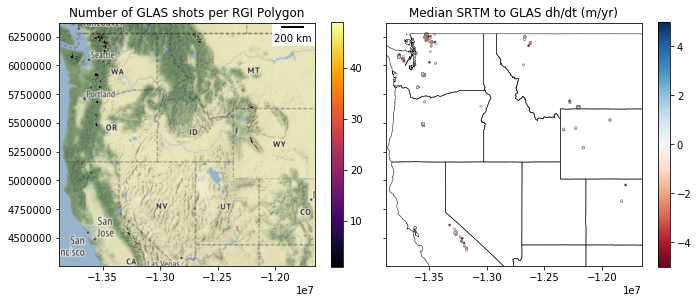

In [100]:
clim = (-5.0, 5.0)
f, axa = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)

rgi_gdf_conus_aea_wm.plot(ax=axa[0], edgecolor='k', facecolor='w', lw=0.5, alpha=0.2);
glas_gdf_aea_rgi_agg_gdf_wm.plot(ax=axa[0],column='glas_srtm_dhdt_count', cmap='inferno', edgecolor='k', lw=0.5, legend=True)
axa[0].set_title('Number of GLAS shots per RGI Polygon')
add_basemap(axa[0], zoom=5)

glas_gdf_aea_rgi_agg_gdf_wm.plot(ax=axa[1],column='glas_srtm_dhdt_median', cmap='RdBu', edgecolor='k', lw=0.5, vmin=clim[0], vmax=clim[1], legend=True)
axa[1].set_title('Median SRTM to GLAS dh/dt (m/yr)')
glas_gdf_aea_rgi_wm.plot(ax=axa[1],column='glas_srtm_dhdt', cmap='RdBu', markersize=5, edgecolor='0.5', lw=0.5, vmin=clim[0], vmax=clim[1])
states_gdf_aea_wm.plot(ax=axa[1], edgecolor='k', facecolor='none', lw=0.5)

plt.tight_layout()

## Zoom to North Cascades

# Can we eek out any additional insight from the reduced data?

## Point density vs. Glacier Area

Do we see more valid GLAS points over bigger glaciers?

Text(0.5, 0, 'Glacier Area (km^2)')

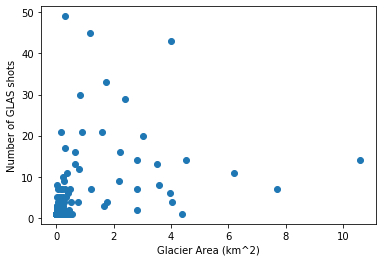

In [101]:
f, ax = plt.subplots()
ax.scatter(glas_gdf_aea_rgi_agg_gdf['Area_first'], glas_gdf_aea_rgi_agg_gdf['glas_srtm_dhdt_count'])
ax.set_ylabel('Number of GLAS shots')
ax.set_xlabel('Glacier Area (km^2)')

## Median dh/dt vs. Glacier Area

Do we see less elevation change over bigger glaciers?

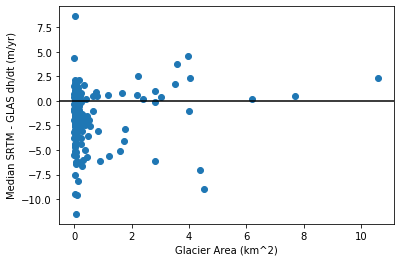

In [102]:
f, ax = plt.subplots()
ax.scatter(glas_gdf_aea_rgi_agg_gdf['Area_first'], glas_gdf_aea_rgi_agg_gdf['glas_srtm_dhdt_median'])
ax.set_xlabel('Glacier Area (km^2)')
ax.set_ylabel('Median SRTM - GLAS dh/dt (m/yr)')
ax.axhline(0, color='k')

## Median dh/dt vs. Glacier Elevation

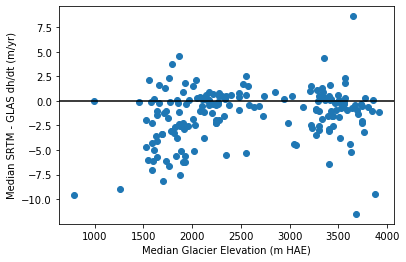

In [103]:
f, ax = plt.subplots()
ax.scatter(glas_gdf_aea_rgi_agg_gdf['glas_z_median'], glas_gdf_aea_rgi_agg_gdf['glas_srtm_dhdt_median'])
ax.set_xlabel('Median Glacier Elevation (m HAE)')
ax.set_ylabel('Median SRTM - GLAS dh/dt (m/yr)')
ax.axhline(0, color='k')

### ¯\\_(ツ)_/¯

## Save output as GIS-ready file

The workflows we're developing with Jupyter Notebooks are intended to be all-inclusive and reproducible - they start by reading raw data and end with final results.

But sometimes you want to write out geospatial data for analysis in a GUI-based GIS (QGIS, ArcMap) to share with colleagues

## How to choose a format?
Under the hood, geopandas uses the `fiona` package for reading/writing vector data

`fiona.supported_drivers`

```
{'ARCGEN': 'r',
 'AeronavFAA': 'r',
 'BNA': 'raw',
 'CSV': 'raw',
 'DGN': 'raw',
 'DXF': 'raw',
 'ESRI Shapefile': 'raw',
 'GML': 'raw',
 'GPKG': 'rw',
 'GPSTrackMaker': 'raw',
 'GPX': 'raw',
 'GeoJSON': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'OpenFileGDB': 'r',
 'PCIDSK': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r'}
 ```

* You've all used shapefiles in the past.  Please stop.  This is a legacy format, though it is still widely used.
* http://switchfromshapefile.org/
* Better options these days are Geopackage (GPKG) when spatial index is required, and GeoJSON for most cases - both should be supported by any respectable GIS
* Let's use geopackage for this exercise
* Now that you've made an informed decision, pick a filename and use the Geopandas `to_file()` method
    * Make sure you properly specify filename with extension and the `driver` option
    * Note: Writing out may take a minute, and may produce an intermediate '.gpkg-journal' file

In [104]:
glas_gdf_aea_rgi_agg_gdf.shape

(185, 11)

In [105]:
glas_gdf_aea_rgi_agg_gdf.head()

,Name_first,Area_first,glas_z_mean,glas_z_median,glas_z_std,glas_srtm_dhdt_count,glas_srtm_dhdt_mean,glas_srtm_dhdt_median,glas_srtm_dhdt_std,glas_pt_density,geometry
RGIId,,,,,,,,,,,
RGI60-02.13741,Hayden Glacier OR,0.808,2367.762500,2351.530,44.709595,12,0.313717,0.521908,0.712847,14.851485,POLYGON ((-598133.6174021332 265564.6568703279...
RGI60-02.13756,OR,0.074,2334.240000,2309.530,40.594923,7,0.780945,0.488872,1.156264,94.594595,POLYGON ((-597218.1615705864 266082.6795769816...
RGI60-02.13761,Thayer Glacier OR,0.104,2577.600000,2577.600,NaN,1,1.482302,1.482302,NaN,9.615385,POLYGON ((-596960.0799126084 266987.2218985451...
RGI60-02.13769,Villard Glacier OR,0.051,2710.566667,2689.840,54.160927,3,-0.500506,-0.549968,0.293306,58.823529,"POLYGON ((-597525.68864642 267742.8300522462, ..."
RGI60-02.13770,Linn Glacier OR,0.144,2453.932500,2394.325,172.569776,4,0.282499,0.585407,0.806818,27.777778,POLYGON ((-597605.7763857148 268593.7655254385...


In [106]:
out_fn='./conus_glas_gdf_aea_rgi_agg.gpkg'
glas_gdf_aea_rgi_agg_gdf.to_file(out_fn, driver='GPKG')

#out_fn='./conus_glas_gdf_aea_rgi_agg.geojson'
#glas_gdf_aea_rgi_agg_gdf.to_file(out_fn, driver='GeoJSON')

## :tada:

You can now directly load this gpkg file in any GIS, without defining a coordinate system or dealing with your original csv.  

Try it! Right-click on file in the file browser (left side of the JupyterLab interface) -> Download.  Then open in QGIS on your local machine.

You can also load this file directly into geopandas in the future using the `read_file()` method, without having to do any of the processing above.

# So, what if we actually had a decent GLAS sample of CONUS glaciers?

## Estimate glacier mass balance

We could have estimated mass balance for each glacier polygon using the mean dh/dt, glacier area, and a standard bulk density (850 kg/m3, Huss, 2013).  Could then perform a secondary aggregation to compile statistics for mountain ranges, watersheds, etc.

With sparse sample, probably best to bin points to derive dh/dt vs. elevation curves, then combine with observed glacier hypsometry to estimate mass balance for glacier polygons.  This can work, but need to be careful about spatial variability.  Some good papers on this for HMA and other regions led by Andy Kaab and Alex Gardner.

# Final thoughts

GLAS was not the right tool for small, low-latitude CONUS glaciers.  We kind of knew this would be the case before we started, but hey, it's worth a look.

The concepts and approaches presented here can be applied to larger glaciers or ice caps, especially at higher latitudes.  One could modify to repeat for all RGI regions.

We started with an existing csv of culled points here.  One could repeat with a similarly processed subset of ATL06 points using the workflows presented earlier this week.  This will provide a longer time period to evaluate noisy elevation measurements.  Replacing void-filled SRTM with another reference DEM is also needed (e.g., the timestamped USGS NED).

Note that the core tools presented here have Dask integration (https://dask.org/) to allow you to chunk and process larger-than-memory datasets with minimal modification to the code.

# Appendix A: Distortion in Polar Stereographic Projections

"The [polar stereographic] projection is defined on the entire sphere, except at one point: the projection point. Where it is defined, the mapping is smooth and bijective. It is conformal, meaning that it preserves angles at which curves meet. It is neither isometric nor area-preserving: that is, it preserves neither distances nor the areas of figures." [Wikipedia]

Most of you are probably using polar stereographic projections, likely the standard EPSG:3031 or EPSG:3413 projections for Antarctica and Greenland, respectively.  These are designed to minimize distortion near the latitude of true scale (71°S for Antarctica and 70°N for Greenland).  This means that area and distance distortion will increase as you move away from this latitude.  So areas or distances measured near the pole will not be equivalent to areas or distances measured on the Antarctic Peninsula.  The difference isn't huge, but is nontrivial (~1-2% for Antarctica I believe).  See https://nsidc.org/data/polar-stereo/ps_grids.html for more details.

The figures here might help illustrate: https://en.wikipedia.org/wiki/Stereographic_projection#Properties

Let's try to illustrate this nuanced, but often overlooked issue.

## Tissot's Indicatrix for polar stereographic projection

Let's use the classic Tissot's Indicatrix plots to show map distortion.

https://en.wikipedia.org/wiki/Tissot%27s_indicatrix

In [107]:
import cartopy
import cartopy.crs as ccrs

#Cartopy implementation of EPSG:3031 and EPSG:3413
crs_3031 = ccrs.SouthPolarStereo(true_scale_latitude=-71)
crs_3413 = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)

#Circle locations
lons = range(-180, 180, 30)
lats = range(-90, 91, 10)
#Radius of circles
rad = 400

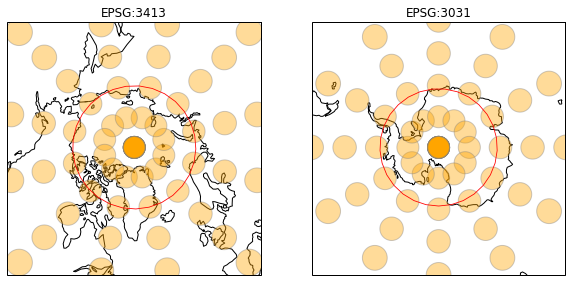

In [108]:
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 2, 1, projection=crs_3413)
ax1.coastlines()
ax1.gridlines(ylocs=[70,],color='r')
ax1.tissot(facecolor='orange', edgecolor='0.5', alpha=0.4, rad_km=rad, lons=lons, lats=lats)
ax1.set_title('EPSG:3413')

ax2 = plt.subplot(1, 2, 2, projection=crs_3031)
ax2.coastlines()
ax2.gridlines(ylocs=[-71,],color='r')
ax2.tissot(facecolor='orange', edgecolor='0.5', alpha=0.4, rad_km=rad, lons=lons, lats=lats)
ax2.set_title('EPSG:3031')
ax2.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

#There is a bug in cartopy extent when central_longitude is not 0
#Get extent in projected crs (x0, x1, y0, y1)
extent_3413 = ax2.get_extent()
ax1.set_extent(extent_3413, crs_3413)
plt.tight_layout()

## OK, cool plot bro.  But why does this matter?

Note the size of the circles in the corners and over the pole, relative to the circles near the latitude of true scale (red line).  While it is unlikely that you'll use this projection to look at mid-latitude regions, you can see the difference in area distortion over the ~20° of latitude between North and South Greenland.

Say you generated amazing elevation difference grids for all of the Greenland ice sheet using ICESat and ICESat-2 crossovers, and you used the EPSG:3413 projection.  Say the grids have a posting (grid cell size) of 120 m.  Imagine didividing the above plots into grid cells.  You'll end up with more grid cells over the circles at lower latitudes (e.g., South Greenland) and fewer grid cells over circles at high latitudes (e.g., North Greenland).  

Let's assume you then integrate your dh/dt values to compute volume change of the Greenland ice sheet by summing dh/dt values for all grid cells in each catchment.  Let's assume all grid cells have the same -1.0 m/yr value.  The integrated estimates for the catchments in South Greenland will have more grid cells, resulting in larger apparent negative volume change!

## Let's compare with an equal-area projection
Lambert Azimuthal Equal-Area is not a bad choice for the polar regions

In [109]:
#Cartopy implementation of EPSG:3031 and EPSG:3413
#crs_slaea = ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
crs_nlaea = ccrs.LambertAzimuthalEqualArea(central_longitude=-45.0, central_latitude=90.0)

#Specify locations of Tissot's Indicatrix
lons = range(-180, 180, 30)
lats = range(-90, 91, 10)
rad = 400

In [110]:
#Add a 100 km grid
dx = 100000
xgrid = np.arange(extent_3413[0], extent_3413[1]+dx, dx)
ygrid = np.arange(extent_3413[2], extent_3413[3]+dx, dx)

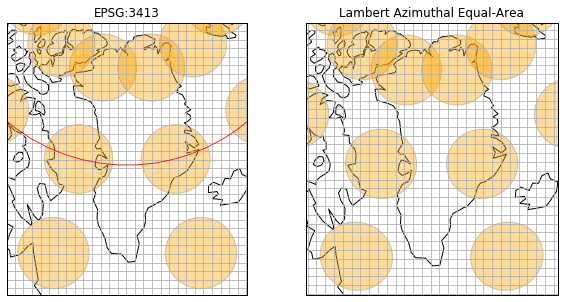

In [111]:
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 2, 1, projection=crs_3413)
ax1.coastlines()
ax1.tissot(facecolor='orange', edgecolor='0.5', alpha=0.4, rad_km=rad, lons=lons, lats=lats)
ax1.set_title('EPSG:3413')
#ax1.gridlines(crs=ccrs.PlateCarree(), ylocs=lats)
ax1.gridlines(crs=crs_3413, xlocs=xgrid, ylocs=ygrid)
ax1.gridlines(ylocs=[70,],color='r')

ax2 = plt.subplot(1, 2, 2, projection=crs_nlaea)
ax2.coastlines()
ax2.tissot(facecolor='orange', edgecolor='0.5', alpha=0.4, rad_km=rad, lons=lons, lats=lats)
ax2.set_title('Lambert Azimuthal Equal-Area')
ax2.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
#ax2.gridlines(crs=ccrs.PlateCarree(), ylocs=lats)
ax2.gridlines(crs=crs_nlaea, xlocs=xgrid, ylocs=ygrid)

#ax1.set_extent(extent_3413, crs_3413)
#ax2.set_extent(extent_3413, crs_3413)

gr_extent = [-1.4E6,1.4E6,-3.7E6,-5.3E5]
ax1.set_extent(gr_extent, crs_3413)
ax2.set_extent(gr_extent, crs_3413)

## Bonus: the "Flat Earth" Projection: Azimuthal Equidistant

![Azimuthal Equidistant](https://upload.wikimedia.org/wikipedia/commons/2/2f/Flat_earth.png)

>An azimuthal equidistant projection of the entire spherical Earth. A rendered picture of the Flat Earth model. The white around the outside of the globe is thought to be an 'Ice Wall', preventing people from falling off the surface of the earth. [Wikipedia]

So, those of you who have been to the South Pole, can you help me understand how this works?

# Appendix B: Sampling a raster at points

This is something that is surprisingly common, but may not be simple to implement.  Let's discuss a few options:
1. Simple `rasterio` sampling with integer indices using nearest neighbor
2. Statistics extracted for a circular window around each point location
3. NumPy array indices, affine/geotransform between pixel and map coordinates, and NumPy/SciPy interpolation

Download sample 90-m SRTM DEM over WA state:  
`aws s3 cp s3://pangeo-data-upload-oregon/icesat2/geospatial-analysis/wa_srtm_90m_full_proj.tif .`

## 1. Rasterio sampling

In [112]:
import os
import rasterio as rio

### Open the file with rasterio

https://rasterio.readthedocs.io/en/stable/

In [113]:
srtm_fn = 'wa_srtm_90m_full_proj.tif'

In [115]:
#This is rasterio Dataset object
src_proj = rio.open(srtm_fn)

In [116]:
print(src_proj.profile)

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 11299, 'height': 8408, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(69.75864688326178, 0.0, 342335.4250030951,
       0.0, -69.75864688326178, 5569416.320597215), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


### Read band 1 as a NumPy array

In [117]:
srtm_proj = src_proj.read(1).astype(float)

In [118]:
srtm_proj

array([[-32768., -32768., -32768., ..., -32768., -32768., -32768.],
       [-32768., -32768., -32768., ..., -32768., -32768., -32768.],
       [-32768., -32768., -32768., ..., -32768., -32768., -32768.],
       ...,
       [-32768., -32768., -32768., ..., -32768., -32768., -32768.],
       [-32768., -32768., -32768., ..., -32768., -32768., -32768.],
       [-32768., -32768., -32768., ..., -32768., -32768., -32768.]])

### Set nodata values to np.nan

In [119]:
srtm_proj[srtm_proj==src_proj.nodata] = np.nan

In [120]:
srtm_proj

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

### Plot to verify

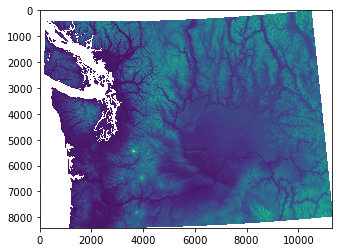

In [121]:
f, ax = plt.subplots()
plt.imshow(srtm_proj)

### Reproject points to match raster

In [122]:
#Raster CRS is UTM 10N (EPSG:32610)
src_proj.crs

CRS.from_epsg(32610)

In [123]:
glas_gdf_utm = glas_gdf_aea.to_crs(src_proj.crs)

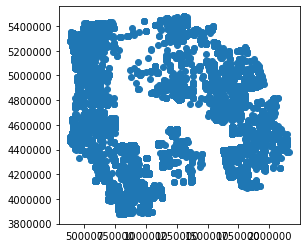

In [124]:
glas_gdf_utm.plot()

### Clip points to raster extent

In [125]:
xmin, ymin, xmax, ymax = src_proj.bounds

In [126]:
glas_gdf_utm_wa = glas_gdf_utm.cx[xmin:xmax, ymin:ymax]

In [127]:
glas_gdf_utm.shape[0]

65236

In [128]:
glas_gdf_utm_wa.shape[0]

7071

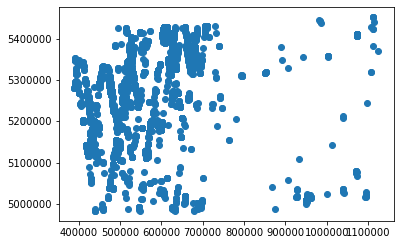

In [129]:
glas_gdf_utm_wa.plot()

### Create tuples of coordinates from Point geometry in GeoDataFrame

In [130]:
glas_coord = [(pt.x, pt.y) for pt in glas_gdf_utm_wa.geometry]
glas_coord[0:3]

[(420253.0739936983, 5125612.37949307),
 (420206.9123479814, 5125953.930917687),
 (420068.6096560212, 5126989.811026541)]

### Sample the raster

In [131]:
srtm_sample = list((src_proj.sample(glas_coord, 1)))

In [132]:
srtm_sample[0:3]

[array([-32768], dtype=int16),
 array([0], dtype=int16),
 array([-32768], dtype=int16)]

### Convert to 1D NumPy array

In [133]:
srtm_sample_elev = np.squeeze(srtm_sample).astype(float)

In [134]:
srtm_sample_elev

array([-32768.,      0., -32768., ..., -32768., -32768.,    659.])

### Set nodata to NaN

In [135]:
srtm_sample_elev[srtm_sample_elev == src_proj.nodata] = np.nan

In [136]:
srtm_sample_elev

array([ nan,   0.,  nan, ...,  nan,  nan, 659.])

### Add to the GeoDataFrame

In [137]:
glas_gdf_utm_wa['srtm_90m_z_rio'] = srtm_sample_elev

In [138]:
glas_gdf_utm_wa.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_srtm_dh,glas_srtm_dt,glas_srtm_dhdt,geometry,srtm_90m_z_rio
465,2003.143756,731268.470836,46.279402,-124.035117,-23.42,-22.25,0.81,31,-1.17,3.031756,-0.385915,POINT (420253.0739936983 5125612.37949307),NaN
466,2003.143756,731268.470836,46.282470,-124.035774,-23.39,-21.81,0.52,31,-1.58,3.031756,-0.521150,POINT (420206.9123479814 5125953.930917687),0.0
467,2003.143756,731268.470838,46.291775,-124.037745,-23.44,-23.53,0.00,31,0.09,3.031756,0.029686,POINT (420068.6096560212 5126989.811026541),NaN
468,2003.143756,731268.470838,46.293329,-124.038072,-23.11,-23.54,0.00,31,0.43,3.031756,0.141832,POINT (420045.6845556927 5127162.808572689),NaN
469,2003.143756,731268.470838,46.294880,-124.038399,-23.98,-22.78,0.26,31,-1.20,3.031756,-0.395810,POINT (420022.756572206 5127335.472931382),NaN


## 2. Local window sample

https://github.com/dshean/demcoreg/blob/master/demcoreg/sample_raster_at_pts.py

https://github.com/dshean/pygeotools/blob/master/pygeotools/lib/geolib.py#L1019

In [139]:
!git clone https://github.com/dshean/pygeotools.git

Cloning into 'pygeotools'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 1304 (delta 44), reused 39 (delta 21), pack-reused 1237
Receiving objects: 100% (1304/1304), 453.39 KiB | 1015.00 KiB/s, done.
Resolving deltas: 100% (943/943), done.
Checking out files: 100% (47/47), done.


In [140]:
!cd pygeotools; pip install -e .

Obtaining file:///home/jovyan/tutorials/geospatial-analysis/pygeotools
  Found existing installation: pygeotools 0.6.0
    Uninstalling pygeotools-0.6.0:
      Successfully uninstalled pygeotools-0.6.0
  Running setup.py develop for pygeotools


In [141]:
from pygeotools.lib import geolib

In [142]:
geolib.sample?

Signature:
geolib.sample(
    ['ds', 'mX', 'mY', 'xy_srs=None', 'bn=1', 'pad=0', 'min_samp_perc=50', 'circ=False', 'count=False'],
)
Docstring:
Sample input dataset at map coordinates

This is a generic sampling function, and will return value derived from window (dimensions pad*2+1) around each point

By default, assumes input map coords are identical to ds srs.  If different, specify xy_srs to enable conversion.
File:      ~/src/icesat2hack/tutorial_dev/shean_UWGDA_w2019_notebooks/pygeotools/pygeotools/lib/geolib.py
Type:      function


In [143]:
#This doesn't play nicely with rasterio
#from osgeo import gdal
#ds = gdal.Open(srtm_fn)

In [144]:
#geolib.sample(ds, glas_gdf_utm_wa.geometry.x.values, glas_gdf_utm_wa.geometry.y.values, pad=2, circ=True)

## Generate shaded relief map for visualization

In [145]:
hs_fn = os.path.splitext(srtm_fn)[0]+'_hs.tif'
!gdaldem hillshade $srtm_fn $hs_fn

0...10...20...30...40...50...60...70...80...90...100 - done.


In [146]:
hs_proj = rio.open(hs_fn)
hs = hs_proj.read(1).astype(float)

In [147]:
hs[hs==hs_proj.nodata] = np.nan

## Plot sample over hillshade

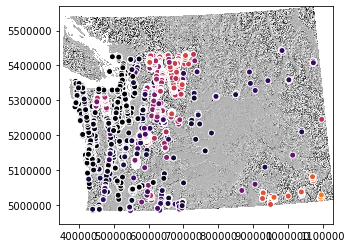

In [148]:
import rasterio.plot
f, ax = plt.subplots()
ax.imshow(hs, cmap='gray', extent=rio.plot.plotting_extent(hs_proj))
glas_gdf_utm_wa.plot('srtm_90m_z_rio', ax=ax, edgecolor='w', cmap='inferno')

## Notes on sampling coarse rasters or noisy rasters at integer pixel locations
* The rasterio approach is efficient, but it uses "nearest neighbor" approach to extract the elevation value for the grid cell that contains the point, regradless of where the point falls within the grid cell (center vs. corner)
* But our grid cells can be big (~90x90 m for the SRTM3 data)
* A better approach would be to use bilinear or bicubic sampling, to interpolate the elevatoin value at the point coordinates
* Another approach uses pixels within some radius of the point location, then computes stats (e.g., median elevation)
    * https://github.com/dshean/pygeotools/blob/master/pygeotools/lib/geolib.py#L1019
    * https://www.earthdatascience.org/courses/earth-analytics-python/lidar-remote-sensing-uncertainty/extract-data-from-raster/

# Appendix C: Elevation Point Query APIs

New functions in pygeotools geolib

Query USGS NED and Open Elevation APIs for lat/lon coordinates  
Query NGS geoid offset API for datum conversions

In [149]:
lat = glas_gdf_utm_wa.iloc[0:5]['lat'].values
lon = glas_gdf_utm_wa.iloc[0:5]['lon'].values

In [150]:
ned_z = geolib.get_HAE(lon, lat)

USGS elevation MSL: 1.77
USGS elevation MSL: 1.77
USGS elevation MSL: 2.30
USGS elevation MSL: 0.74
USGS elevation MSL: 0.73
USGS elevation MSL: 1.70
NGS geoid offset: -24.27
NGS geoid offset: -24.27
NGS geoid offset: -24.27
NGS geoid offset: -24.28
NGS geoid offset: -24.28
NGS geoid offset: -24.28


In [151]:
ned_z

array([-22.499, -21.972, -23.539, -23.551, -22.582])

In [152]:
temp = glas_gdf_utm_wa.iloc[0:5][['glas_z', 'dem_z']]

In [153]:
temp['ned_z'] = ned_z

In [154]:
temp

,glas_z,dem_z,ned_z
465,-23.42,-22.25,-22.499
466,-23.39,-21.81,-21.972
467,-23.44,-23.53,-23.539
468,-23.11,-23.54,-23.551
469,-23.98,-22.78,-22.582
